In [1]:
!pip install qiskit

#initialization
import matplotlib.pyplot as plt
import numpy as np

# importing Qiskit
from qiskit import IBMQ, Aer, assemble, transpile
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.providers.ibmq import least_busy

# import basic plot tools
from qiskit.visualization import plot_histogram

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# 2.1 Grover's Search

## Edit the oracle below so that the searched bitstring is not 111, but 101 and 110 together.

Follow https://learn.qiskit.org/course/ch-algorithms/grovers-algorithm#3qubits
for additional aid.

Defining the oracle for the bitstring 111

In [2]:
qc = QuantumCircuit(3)

qc.h(0)
qc.ccx(1,2,0)
qc.h(0)

oracle_ex3 = qc.to_gate()
oracle_ex3.name = "U$_\omega$"

qc.draw()

┌───┐┌───┐┌───┐
q_0: ┤ H ├┤ X ├┤ H ├
     └───┘└─┬─┘└───┘
q_1: ───────■───────
            │       
q_2: ───────■───────

Create a function that applies H gates to the qubits before applying the oracle.

In [3]:
def initialize_s(qc, qubits):
    """Apply a H-gate to 'qubits' in qc"""
    for q in qubits:
        qc.h(q)
    return qc

Define the diffuser circuit

In [4]:
def diffuser(nqubits):
    qc = QuantumCircuit(nqubits)
    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(nqubits):
        qc.h(qubit)
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        qc.x(qubit)
    # Do multi-controlled-Z gate
    qc.h(nqubits-1)
    qc.mct(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
    qc.h(nqubits-1)
    # Apply transformation |11..1> -> |00..0>
    for qubit in range(nqubits):
        qc.x(qubit)
    # Apply transformation |00..0> -> |s>
    for qubit in range(nqubits):
        qc.h(qubit)
    # We will return the diffuser as a gate
    U_s = qc.to_gate()
    U_s.name = "U$_s$"
    return U_s

Define the complete Grover circuit by combing the oracle and the diffuser.

In [5]:
n = 3
grover_circuit = QuantumCircuit(n)
grover_circuit = initialize_s(grover_circuit, [0,1,2])
grover_circuit.append(oracle_ex3, [0,1,2])
grover_circuit.append(diffuser(n), [0,1,2])
grover_circuit.measure_all()
grover_circuit.draw()

┌───┐┌─────────────┐┌────────┐ ░ ┌─┐      
   q_0: ┤ H ├┤0            ├┤0       ├─░─┤M├──────
        ├───┤│             ││        │ ░ └╥┘┌─┐   
   q_1: ┤ H ├┤1 U$_\omega$ ├┤1 U$_s$ ├─░──╫─┤M├───
        ├───┤│             ││        │ ░  ║ └╥┘┌─┐
   q_2: ┤ H ├┤2            ├┤2       ├─░──╫──╫─┤M├
        └───┘└─────────────┘└────────┘ ░  ║  ║ └╥┘
meas: 3/══════════════════════════════════╩══╩══╩═
                                          0  1  2

{'001': 28, '100': 30, '110': 41, '101': 34, '000': 34, '010': 28, '011': 48, '111': 781}


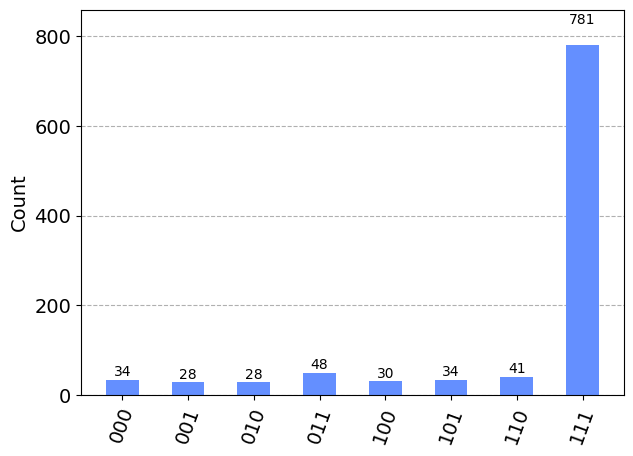

In [6]:
# Use Aer's qasm_simulator
backend_sim = Aer.get_backend('qasm_simulator')

# Execute the circuit on the qasm simulator.
# We've set the number of repeats of the circuit
# to be 1024, which is the default.
job_sim = backend_sim.run(transpile(grover_circuit, backend_sim), shots=1024)

# Grab the results from the job.
result_sim = job_sim.result()

counts = result_sim.get_counts(grover_circuit)
print(counts)

plot_histogram(counts)

# Exercise

Redefine the oracle for bitsrings 101 and 110 together.

In [7]:
qc = QuantumCircuit(3)
qc.cz(0, 2)
qc.cz(1, 2)
oracle_ex3 = qc.to_gate()
oracle_ex3.name = "U$_\omega$"

The diffuser fuction could be reused to define a new circuit 

In [8]:
n = 3
grover_circuit_ex = QuantumCircuit(n)
grover_circuit_ex = initialize_s(grover_circuit_ex , [0,1,2])
grover_circuit_ex.append(oracle_ex3, [0,1,2])
grover_circuit_ex.append(diffuser(n), [0,1,2])
grover_circuit_ex.measure_all()
grover_circuit_ex.draw()

┌───┐┌─────────────┐┌────────┐ ░ ┌─┐      
   q_0: ┤ H ├┤0            ├┤0       ├─░─┤M├──────
        ├───┤│             ││        │ ░ └╥┘┌─┐   
   q_1: ┤ H ├┤1 U$_\omega$ ├┤1 U$_s$ ├─░──╫─┤M├───
        ├───┤│             ││        │ ░  ║ └╥┘┌─┐
   q_2: ┤ H ├┤2            ├┤2       ├─░──╫──╫─┤M├
        └───┘└─────────────┘└────────┘ ░  ║  ║ └╥┘
meas: 3/══════════════════════════════════╩══╩══╩═
                                          0  1  2

Run the new circuit using the Aer simulator

{'101': 520, '110': 504}


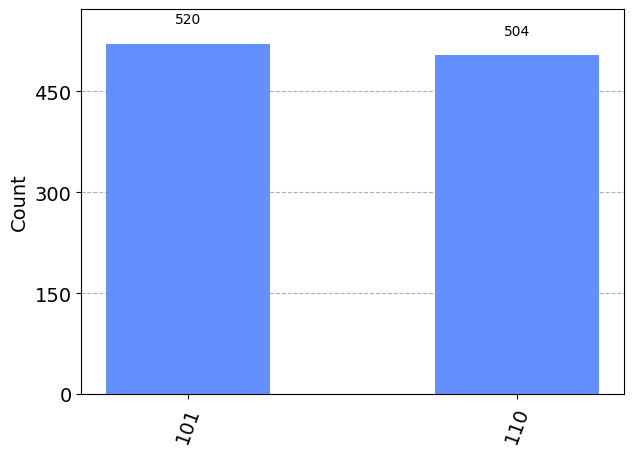

In [9]:
# Use Aer's qasm_simulator
backend_sim = Aer.get_backend('qasm_simulator')

# Execute the circuit on the qasm simulator.
# We've set the number of repeats of the circuit
# to be 1024, which is the default.
job_sim_ex = backend_sim.run(transpile(grover_circuit_ex, backend_sim), shots=1024)

# Grab the results from the job.
result_sim_ex = job_sim_ex.result()

counts = result_sim_ex.get_counts(grover_circuit_ex)
print(counts)

plot_histogram(counts)

### 2.2 Solutions - Construct 3 qbit qft circuit

The figure below shows how a circuit for implementing QFT for three qubit system looks like.

The circuit for 3 qubits has controlled rotation gates between qubits.
You can try going through 3, 4 and 5 qubits to get a sense of how to build a QFT circuit for an arbitrary number of qubits

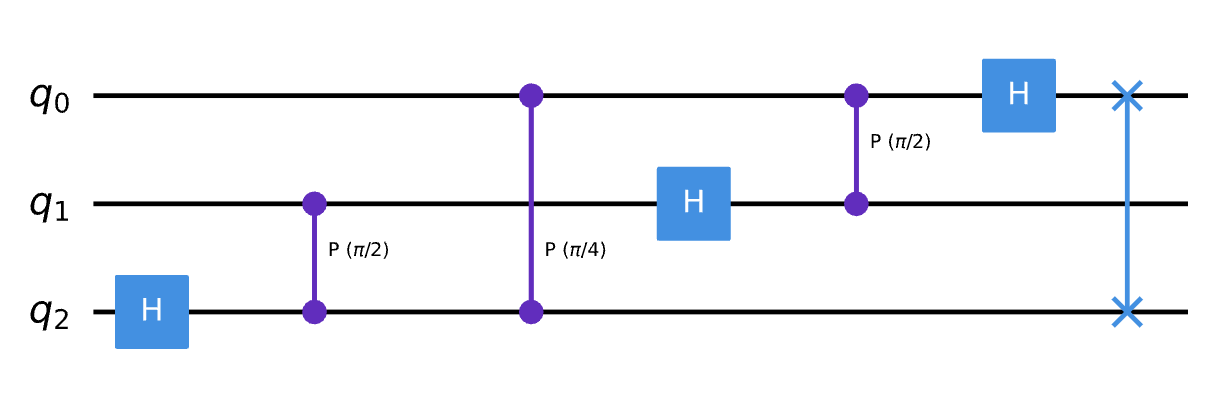

This is the circuit we're required to implement

In [10]:
#Hadamard on q2 followed by corresponding rotation operations on q2
pi = np.pi
QFT_cirq = QuantumCircuit(3)
QFT_cirq.h(2)
QFT_cirq.cp(pi/2, 1, 2) # CROT from qubit 1 to qubit 2

QFT_cirq.cp(pi/4, 0, 2) # CROT from qubit 0 to qubit 2
QFT_cirq.draw()

q_0: ───────────────■───────
                    │       
q_1: ──────■────────┼───────
     ┌───┐ │P(π/2)  │P(π/4) 
q_2: ┤ H ├─■────────■───────
     └───┘

In [11]:
#Hadamard on q1 followed by corresponding rotation operations on q1
QFT_cirq.h(1)
QFT_cirq.cp(pi/2,0,1)
#Write your code here

In [12]:
#Hadamard on q0 
QFT_cirq.h(0)
QFT_cirq.swap(0,2)
#Write your code here

In [13]:
#Swap operations as final step of the process
QFT_cirq.measure_all()
QFT_cirq.draw()

#Write your code here

┌───┐    ░ ┌─┐      
   q_0: ───────────────■─────────────■───────┤ H ├─X──░─┤M├──────
                       │       ┌───┐ │P(π/2) └───┘ │  ░ └╥┘┌─┐   
   q_1: ──────■────────┼───────┤ H ├─■─────────────┼──░──╫─┤M├───
        ┌───┐ │P(π/2)  │P(π/4) └───┘               │  ░  ║ └╥┘┌─┐
   q_2: ┤ H ├─■────────■───────────────────────────X──░──╫──╫─┤M├
        └───┘                                         ░  ║  ║ └╥┘
meas: 3/═════════════════════════════════════════════════╩══╩══╩═
                                                         0  1  2

In [14]:
# Run your code on simulator of choice
# Use Aer's qasm_simulator
backend_sim = Aer.get_backend('qasm_simulator')

# Execute the circuit on the qasm simulator.
# We've set the number of repeats of the circuit
# to be 1024, which is the default.
job_sim_ex = backend_sim.run(transpile(QFT_cirq, backend_sim), shots=1024)

# Grab the results from the job.
result_sim_ex = job_sim_ex.result()



{'000': 128, '010': 141, '110': 127, '001': 136, '100': 107, '011': 129, '111': 130, '101': 126}


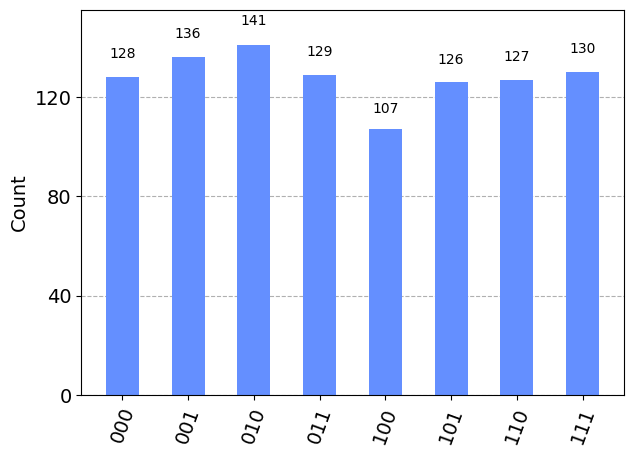

In [15]:
#Display results on plot
counts = result_sim_ex.get_counts(QFT_cirq)
print(counts)
#Plot results
from qiskit.visualization import plot_histogram
plot_histogram(counts)
#Write your code here

Use inbuilt QFT cicuit class defined in section 8 to build the circuit for 3 qubits and simulate it

https://qiskit.org/documentation/stable/0.24/stubs/qiskit.circuit.library.QFT.html

In [16]:
QFT_Class = QuantumCircuit(3)
import qiskit.circuit.library as lib
QFT = lib.QFT(num_qubits = 3)
QFT_Class.append(QFT,[0,1,2])
QFT_Class.measure_all()
QFT_Class.draw()

┌──────┐ ░ ┌─┐      
   q_0: ┤0     ├─░─┤M├──────
        │      │ ░ └╥┘┌─┐   
   q_1: ┤1 QFT ├─░──╫─┤M├───
        │      │ ░  ║ └╥┘┌─┐
   q_2: ┤2     ├─░──╫──╫─┤M├
        └──────┘ ░  ║  ║ └╥┘
meas: 3/════════════╩══╩══╩═
                    0  1  2

{'101': 126, '100': 133, '000': 129, '010': 136, '110': 129, '011': 113, '111': 129, '001': 129}


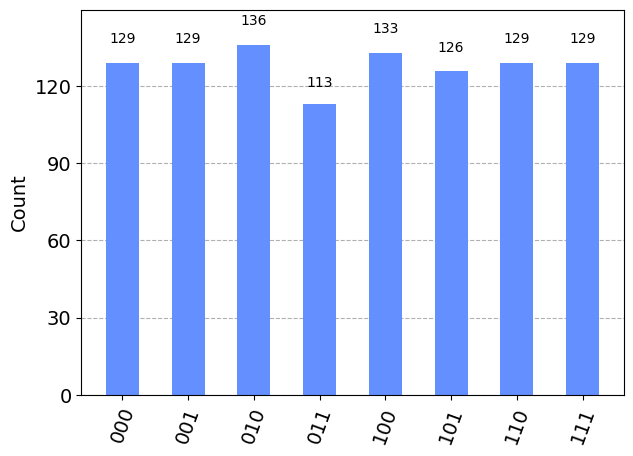

In [17]:
# Run your code on simulator of choice
# Use Aer's qasm_simulator
backend_sim = Aer.get_backend('qasm_simulator')

# Execute the circuit on the qasm simulator.
# We've set the number of repeats of the circuit
# to be 1024, which is the default.
job_sim_ex = backend_sim.run(transpile(QFT_Class, backend_sim), shots=1024)

# Grab the results from the job.
result_sim_ex = job_sim_ex.result()

#Display results on plot
counts = result_sim_ex.get_counts(QFT_Class)
print(counts)
#Plot results
from qiskit.visualization import plot_histogram
plot_histogram(counts)
#Write your code here

Invert the output of the first circuit using the same circuit class by changing the inverse flag as "True"  to show that we get the same input vector

In [18]:
#Hadamard on q2 followed by corresponding rotation operations on q2
pi = np.pi
QFT_cirq_inv = QuantumCircuit(3)
QFT_cirq_inv.h(2)
QFT_cirq_inv.cp(pi/2, 1, 2) # CROT from qubit 1 to qubit 2

QFT_cirq_inv.cp(pi/4, 0, 2) # CROT from qubit 0 to qubit 2

#Hadamard on q1 followed by corresponding rotation operations on q1
QFT_cirq_inv.h(1)
QFT_cirq.cp(pi/2,0,1)

#Hadamard on q0 
QFT_cirq_inv.h(0)
QFT_cirq_inv.swap(0,2)
#Using inbuilt QFT Class to invert the output of the QFT and appending to originak QFT circuit
QFT_inv = lib.QFT(num_qubits = 3, inverse = True)
QFT_cirq_inv.append(QFT_inv,[0,1,2])
QFT_cirq_inv.measure_all()
QFT_cirq_inv.draw()


┌───┐   ┌───────┐ ░ ┌─┐      
   q_0: ───────────────■───────┤ H ├─X─┤0      ├─░─┤M├──────
                       │       ├───┤ │ │       │ ░ └╥┘┌─┐   
   q_1: ──────■────────┼───────┤ H ├─┼─┤1 IQFT ├─░──╫─┤M├───
        ┌───┐ │P(π/2)  │P(π/4) └───┘ │ │       │ ░  ║ └╥┘┌─┐
   q_2: ┤ H ├─■────────■─────────────X─┤2      ├─░──╫──╫─┤M├
        └───┘                          └───────┘ ░  ║  ║ └╥┘
meas: 3/════════════════════════════════════════════╩══╩══╩═
                                                    0  1  2

{'000': 1024}


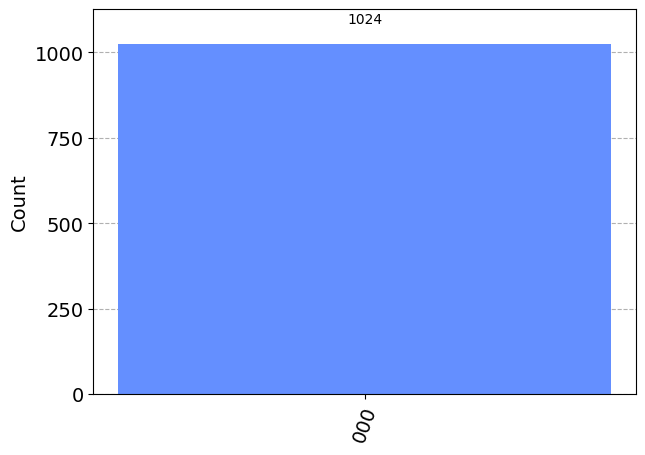

In [19]:
# Run your code on simulator of choice
# Use Aer's qasm_simulator
backend_sim = Aer.get_backend('qasm_simulator')

# Execute the circuit on the qasm simulator.
# We've set the number of repeats of the circuit
# to be 1024, which is the default.
job_sim_ex = backend_sim.run(transpile(QFT_cirq_inv, backend_sim), shots=1024)

# Grab the results from the job.
result_sim_ex = job_sim_ex.result()

#Display results on plot
counts = result_sim_ex.get_counts(QFT_cirq_inv)
print(counts)
#Plot results
from qiskit.visualization import plot_histogram
plot_histogram(counts)
#Write your code here